In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn_keras as iso
from aparent_losses import *

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

def plot_position_delta_scatter(df, min_pred_filter=0.0, sort_pred=True, figsize=(14,6), dot_size=12, dot_alpha=0.5, vmin=-0.5, vmax=0.45, show_stats=True, fig_name=None, plot_start=-50, plot_end=100, fig_dpi=300, annotate=None, bg_df=None, pred_column='delta_logodds_pred', true_column='delta_logodds_true', snv_pos_column='snv_pos') :
    fig = plt.figure(figsize=figsize)

    keep_index = np.abs(np.ravel(df[pred_column].values)) >= min_pred_filter
    df = df.loc[keep_index]
    
    annotation_height = 1.0
    if 'psi' in true_column :
        annotation_height = 0.15
    
    border_eta = 0.00
    
    if bg_df is not None :
        snv_pos = np.ravel(bg_df[snv_pos_column].values) - 50
        delta_logodds_true = np.ravel(bg_df[true_column].values)
        delta_logodds_pred = np.ravel(bg_df[pred_column].values)

        sort_index = np.argsort(np.abs(delta_logodds_pred))
        snv_pos = snv_pos[sort_index]
        delta_logodds_true = delta_logodds_true[sort_index]
        delta_logodds_pred = delta_logodds_pred[sort_index]
        
        delta_logodds_true[delta_logodds_true < 0.0] -= annotation_height

        plt.scatter(snv_pos, delta_logodds_true, c=delta_logodds_pred, cmap="bwr", vmin=-0.5, vmax=0.45, alpha=0.01, s=12)
    
    snv_pos = np.ravel(df[snv_pos_column].values) - 50
    delta_logodds_true = np.ravel(df[true_column].values)
    delta_logodds_pred = np.ravel(df[pred_column].values)
    
    r_val, p_val = pearsonr(delta_logodds_true, delta_logodds_pred)
    n_points = len(df)

    if sort_pred :
        sort_index = np.argsort(np.abs(delta_logodds_pred))
        snv_pos = snv_pos[sort_index]
        delta_logodds_true = delta_logodds_true[sort_index]
        delta_logodds_pred = delta_logodds_pred[sort_index]

    delta_logodds_true[delta_logodds_true < 0.0] -= annotation_height
    ax = plt.gca()
    ax.add_patch(Rectangle((-50 + border_eta, -annotation_height + border_eta), 50 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
    ax.add_patch(Rectangle((0 + border_eta, -annotation_height + border_eta), 6 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='darkgreen', edgecolor='black', lw=4))
    ax.add_patch(Rectangle((6 + border_eta, -annotation_height + border_eta), 54 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
    ax.add_patch(Rectangle((60 + border_eta, -annotation_height + border_eta), 75 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))

    #ax.text(-25, -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")
    #ax.text(33, -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")
    #ax.text(85, -annotation_height/2., 'FDSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")
    
    use_start = plot_start
    use_end = 0
    if use_end - use_start > 10 :
        ax.text(use_start + (use_end - use_start) / 2., -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")
    
    dse_start = 6
    dse_end = min(60, plot_end)
    if dse_end - dse_start > 10 :
        ax.text(dse_start + (dse_end - dse_start) / 2., -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")
    
    fdse_start = 60
    fdse_end = min(60 + 75, plot_end)
    if fdse_end - fdse_start > 10 :
        ax.text(fdse_start + (fdse_end - fdse_start) / 2., -annotation_height/2., 'FDSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

    
    plt.scatter(snv_pos, delta_logodds_true, c=delta_logodds_pred, cmap="bwr", vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)
    #plt.plot([np.min(snv_pos), np.max(snv_pos)], [0, 0], c='darkred', linewidth=2, linestyle='--')
    
    annot_text = 'R^2 = ' + str(round(r_val * r_val, 2))
    annot_text += '\nn = ' + str(n_points)
    
    if show_stats :
        ax = plt.gca()
        ax.text(0.90, 0.80, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

    if plot_start != -50 or plot_end != 100 :
        plt.xticks([plot_start, 0, 6, plot_end], [plot_start, 0, 6, plot_end], fontsize=18)
    else :
        plt.xticks([-100, -50, -25, 0, 6, 25, 50, 100], [-100, -50, -25, 0, 6, 25, 50, 100], fontsize=18)
    
    if not 'psi' in true_column :
        plt.yticks([-7, -5, -3, -1, 0, 2, 4], [-6, -4, -2, 0, 0, 2, 4], fontsize=18)
    else :
        plt.yticks([-1.0 - annotation_height, -0.5 - annotation_height, 0 - annotation_height, 0, 0.5, 1.0], [-1.0, -0.5, 0, 0, 0.5, 1.0], fontsize=18)
    
    #plt.axis([np.min(snv_pos), np.max(snv_pos), np.min((delta_logodds_true)), np.max((delta_logodds_true))])
    plt.axis([-50, 100, -6., 4.])

    plt.xlabel('Position relative to pPAS', fontsize=18)
    plt.ylabel('Observed Delta pPAS logodds', fontsize=18)
    plt.title('Position vs. Delta Usage', fontsize=18)

    plt.xlim(plot_start, plot_end)
    if not 'psi' in true_column :
        plt.ylim(-7, 4)
    else :
        plt.ylim(-1 - annotation_height, 1)
    
    plt.tight_layout()
    
    if fig_name is not None :
        plt.savefig(fig_name + '.png', dpi=fig_dpi, transparent=True)
        plt.savefig(fig_name + '.eps')
    plt.show()


Using TensorFlow backend.


In [2]:
#Load plasmid data
plasmid_dict = pickle.load(open('apa_plasmid_data.pickle', 'rb'))
plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']

#Generate training and test set indexes
valid_set_size = 0.025
test_set_size = 0.025

plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))

Training set size = 3620426
Validation set size = 95274
Test set size = 95274


In [3]:
prox_range = (np.arange(25, dtype=np.int) + 80).tolist()
norm_range = np.arange(206).tolist()

unique_libraries = np.array(['tomm5_up_n20c20_dn_c20', 'tomm5_up_c20n20_dn_c20', 'tomm5_up_n20c20_dn_n20', 'tomm5_up_c20n20_dn_n20', 'doubledope', 'simple', 'atr', 'hsp', 'snh', 'sox', 'wha', 'array', 'aar'], dtype=np.object)

test_plasmid_gen = iso.DataGenerator(
    plasmid_test_index,
    {'df' : plasmid_df, 'cuts' : plasmid_cuts},
    batch_size=32,
    inputs = [
        {
            'id' : 'seq',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : iso.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
            'encoder' : iso.OneHotEncoder(seq_length=205),
            'dim' : (205, 4, 1),
            'sparsify' : False
        },
        {
            'id' : 'lib',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['library'],
            'encoder' : iso.CategoricalEncoder(n_categories=len(unique_libraries), categories=unique_libraries),
            'sparsify' : False
        },
        {
            'id' : 'distal_pas',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: 1 if row['library_index'] in [2, 5, 8, 11, 20, 40] else 0,
            'encoder' : None,
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'prox_usage',
            'source_type' : 'matrix',
            'source' : 'cuts',
            'extractor' : iso.CountExtractor(start_pos=180, end_pos=180 + 205, static_poses=[-1], sparse_source=True),
            'transformer' : iso.ProportionTransformer(prox_range, norm_range, laplace_smoothing=0.0),#0.000005),
            'sparsify' : False
        },
        {
            'id' : 'prox_cuts',
            'source_type' : 'matrix',
            'source' : 'cuts',
            'extractor' : iso.CountExtractor(start_pos=180, end_pos=180 + 205, static_poses=[-1], sparse_source=True),
            'transformer' : iso.MultiProportionTransformer(n_classes=206, laplace_smoothing=0.0),#0.000005),
            'sparsify' : False
        },
    ],
    randomizers = [],
    shuffle = False
)

In [38]:
#Load model

save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_large_all_libs.h5'
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights_partitioned.h5'
model_path = os.path.join(save_dir, model_name)

model = load_model(model_path)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CNN Test set logodds Pearson r^2 = 0.87


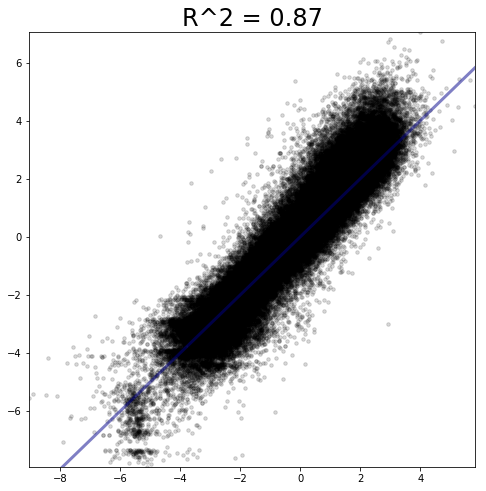

Iso vs. Cut-Iso r^2 = 0.99


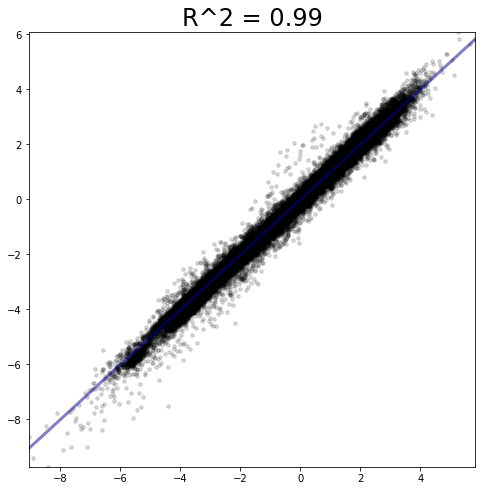

In [39]:
from scipy.stats import pearsonr

#Predict from test data generator
iso_pred, cut_pred = model.predict_generator(test_plasmid_gen, workers=1, use_multiprocessing=False)

#Gather true (observed) isoform proportions and cut distributions
iso_true = np.concatenate([test_plasmid_gen[i][1][0] for i in range(len(test_plasmid_gen))], axis=0)
cut_true = np.concatenate([test_plasmid_gen[i][1][1] for i in range(len(test_plasmid_gen))], axis=0)
lib_index = np.concatenate([test_plasmid_gen[i][0][1] for i in range(len(test_plasmid_gen))], axis=0)

#Filter nan-logits
keep_index = (iso_true[:, 0] > 0.0001) & (iso_true[:, 0] < 0.9999)
iso_true = iso_true[keep_index]
iso_pred = iso_pred[keep_index]
cut_true = cut_true[keep_index]
cut_pred = cut_pred[keep_index]
lib_index = lib_index[keep_index]

#Calculate isoform logits
logodds_pred = np.ravel(np.log(iso_pred / (1. - iso_pred)))
logodds_true = np.ravel(np.log(iso_true / (1. - iso_true)))

#Compute pearson r correlation
r_val, _ = pearsonr(logodds_pred, logodds_true)

print('CNN Test set logodds Pearson r^2 = ' + str(round(r_val**2, 2)))

f = plt.figure(figsize=(8, 8))

plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
min_x = max(np.min(logodds_pred), np.min(logodds_true))
max_x = min(np.max(logodds_pred), np.max(logodds_true))
min_y = max(np.min(logodds_pred), np.min(logodds_true))
max_y = min(np.max(logodds_pred), np.max(logodds_true))
plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_true), np.max(logodds_true)])
plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
plt.show()
plt.close()

#This test shows that cumulative cuts correlate with isoform prediction
iso_pred_cuts = np.sum(cut_pred[:, 80:80+25], axis=1)
logodds_pred_cuts = np.ravel(np.log(iso_pred_cuts / (1. - iso_pred_cuts)))

r_val, _ = pearsonr(logodds_pred, logodds_pred_cuts)

print('Iso vs. Cut-Iso r^2 = ' + str(round(r_val**2, 2)))

f = plt.figure(figsize=(8, 8))

plt.scatter(logodds_pred, logodds_pred_cuts, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
min_x = max(np.min(logodds_pred), np.min(logodds_pred_cuts))
max_x = min(np.max(logodds_pred), np.max(logodds_pred_cuts))
min_y = max(np.min(logodds_pred), np.min(logodds_pred_cuts))
max_y = min(np.max(logodds_pred), np.max(logodds_pred_cuts))
plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_pred_cuts), np.max(logodds_pred_cuts)])
plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
plt.show()
plt.close()

Iso vs. Cut-Iso r^2 = 0.87


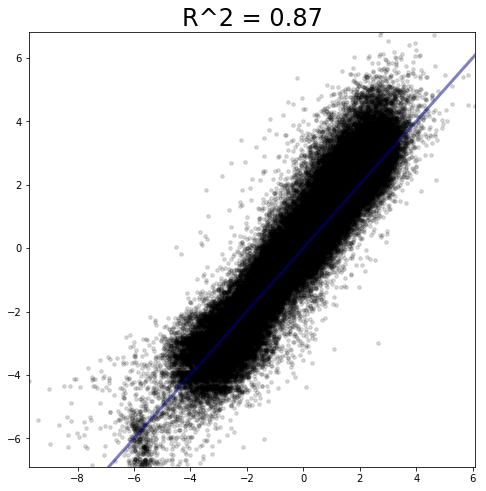

In [40]:
#This test shows that cumulative cuts correlate with isoform prediction
iso_pred_cuts = np.sum(cut_pred[:, 80:80+25], axis=1)
iso_true_cuts = np.sum(cut_true[:, 80:80+25], axis=1)

lib_index_cuts = np.zeros(lib_index.shape[0])
lib_index_cuts[:] = np.argmax(lib_index[:, :], axis=1)

keep_index = (iso_true_cuts > 0.001) & (iso_true_cuts < 0.999)
iso_true_cuts = iso_true_cuts[keep_index]
iso_pred_cuts = iso_pred_cuts[keep_index]
lib_index_cuts = lib_index_cuts[keep_index]

logodds_pred_cuts = np.ravel(np.log(iso_pred_cuts / (1. - iso_pred_cuts)))
logodds_true_cuts = np.ravel(np.log(iso_true_cuts / (1. - iso_true_cuts)))

r_val, _ = pearsonr(logodds_pred_cuts, logodds_true_cuts)

print('Iso vs. Cut-Iso r^2 = ' + str(round(r_val**2, 2)))

f = plt.figure(figsize=(8, 8))

plt.scatter(logodds_pred_cuts, logodds_true_cuts, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
min_x = max(np.min(logodds_pred_cuts), np.min(logodds_true_cuts))
max_x = min(np.max(logodds_pred_cuts), np.max(logodds_true_cuts))
min_y = max(np.min(logodds_pred_cuts), np.min(logodds_true_cuts))
max_y = min(np.max(logodds_pred_cuts), np.max(logodds_true_cuts))
plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

plt.axis([np.min(logodds_pred_cuts), np.max(logodds_pred_cuts), np.min(logodds_true_cuts), np.max(logodds_true_cuts)])
plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
plt.show()
plt.close()

Library = tomm5_up_n20c20_dn_c20
Iso vs. Cut-Iso r^2 = 0.56


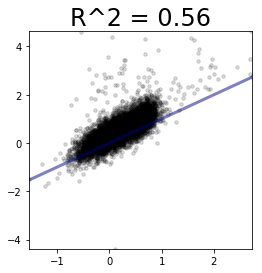

Library = tomm5_up_c20n20_dn_c20
Iso vs. Cut-Iso r^2 = 0.59


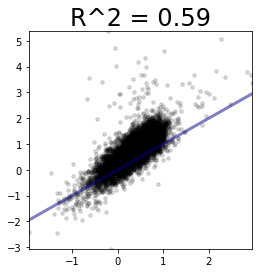

Library = tomm5_up_n20c20_dn_n20
Iso vs. Cut-Iso r^2 = 0.66


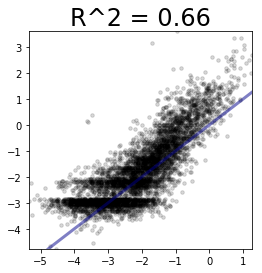

Library = tomm5_up_c20n20_dn_n20
Iso vs. Cut-Iso r^2 = 0.78


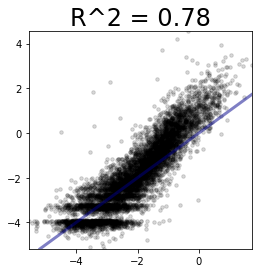

Library = doubledope
Iso vs. Cut-Iso r^2 = 0.79


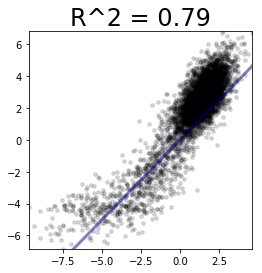

Library = simple
Iso vs. Cut-Iso r^2 = 0.83


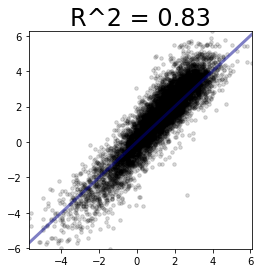

Library = atr
Iso vs. Cut-Iso r^2 = 0.73


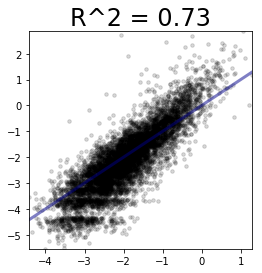

Library = hsp
Iso vs. Cut-Iso r^2 = 0.77


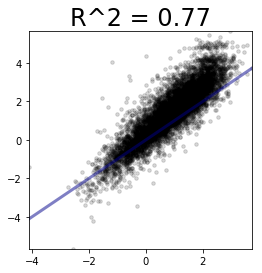

Library = snh
Iso vs. Cut-Iso r^2 = 0.76


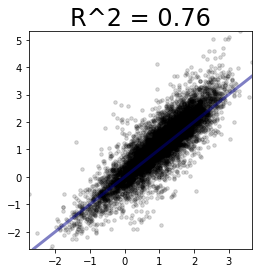

Library = sox
Iso vs. Cut-Iso r^2 = 0.66


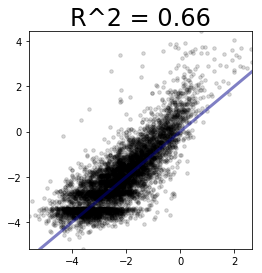

Library = wha
Iso vs. Cut-Iso r^2 = 0.72


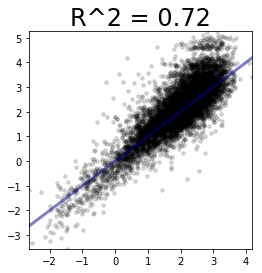

Library = array
Iso vs. Cut-Iso r^2 = 0.92


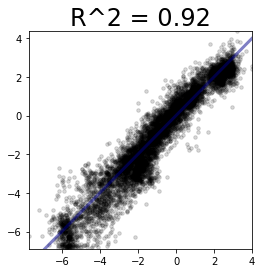

Library = aar
Iso vs. Cut-Iso r^2 = 0.55


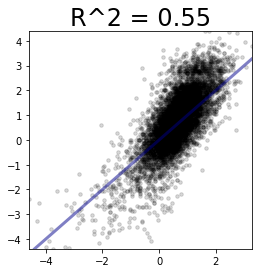

In [41]:

for lib in np.unique(lib_index_cuts) :
    
    iso_true_cuts_lib = iso_true_cuts[lib_index_cuts == lib]
    iso_pred_cuts_lib = iso_pred_cuts[lib_index_cuts == lib]

    logodds_pred_cuts = np.ravel(np.log(iso_pred_cuts_lib / (1. - iso_pred_cuts_lib)))
    logodds_true_cuts = np.ravel(np.log(iso_true_cuts_lib / (1. - iso_true_cuts_lib)))

    r_val, _ = pearsonr(logodds_pred_cuts, logodds_true_cuts)

    print('Library = ' + str(unique_libraries[int(lib)]))
    print('Iso vs. Cut-Iso r^2 = ' + str(round(r_val**2, 2)))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(logodds_pred_cuts, logodds_true_cuts, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
    min_x = max(np.min(logodds_pred_cuts), np.min(logodds_true_cuts))
    max_x = min(np.max(logodds_pred_cuts), np.max(logodds_true_cuts))
    min_y = max(np.min(logodds_pred_cuts), np.min(logodds_true_cuts))
    max_y = min(np.max(logodds_pred_cuts), np.max(logodds_true_cuts))
    plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

    plt.axis([np.min(logodds_pred_cuts), np.max(logodds_pred_cuts), np.min(logodds_true_cuts), np.max(logodds_true_cuts)])
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    plt.show()
    plt.close()


Library = tomm5_up_n20c20_dn_c20
Iso vs. Cut-Iso r^2 = 0.6


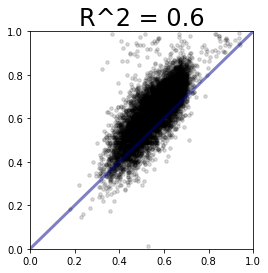

Library = tomm5_up_c20n20_dn_c20
Iso vs. Cut-Iso r^2 = 0.64


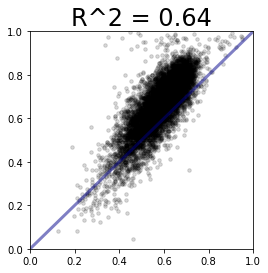

Library = tomm5_up_n20c20_dn_n20
Iso vs. Cut-Iso r^2 = 0.75


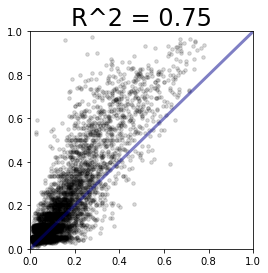

Library = tomm5_up_c20n20_dn_n20
Iso vs. Cut-Iso r^2 = 0.81


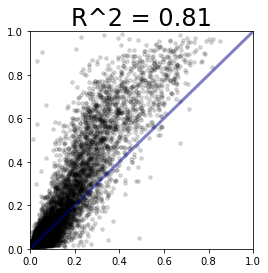

Library = doubledope
Iso vs. Cut-Iso r^2 = 0.82


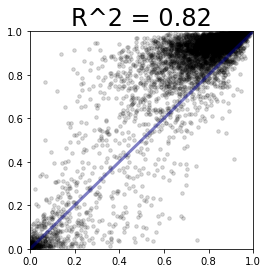

Library = simple
Iso vs. Cut-Iso r^2 = 0.85


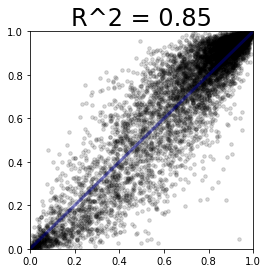

Library = atr
Iso vs. Cut-Iso r^2 = 0.75


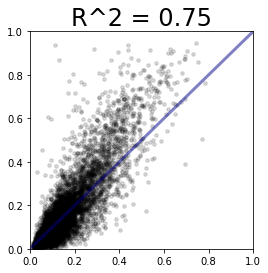

Library = hsp
Iso vs. Cut-Iso r^2 = 0.78


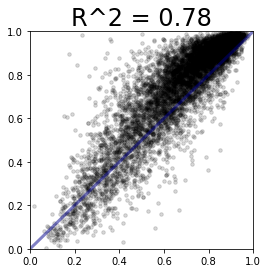

Library = snh
Iso vs. Cut-Iso r^2 = 0.77


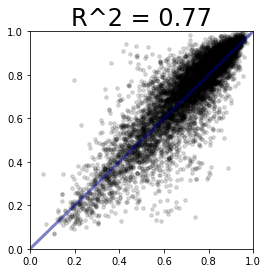

Library = sox
Iso vs. Cut-Iso r^2 = 0.74


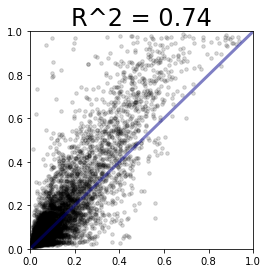

Library = wha
Iso vs. Cut-Iso r^2 = 0.81


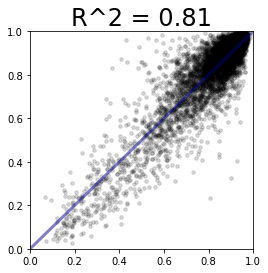

Library = array
Iso vs. Cut-Iso r^2 = 0.94


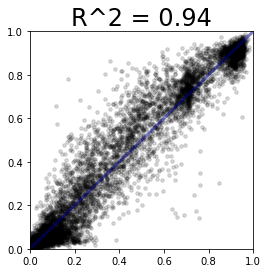

Library = aar
Iso vs. Cut-Iso r^2 = 0.55


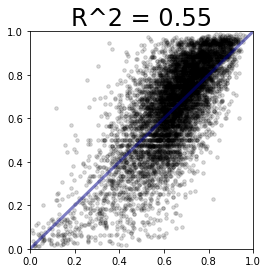

In [42]:

for lib in np.unique(lib_index_cuts) :
    
    iso_true_cuts_lib = iso_true_cuts[lib_index_cuts == lib]
    iso_pred_cuts_lib = iso_pred_cuts[lib_index_cuts == lib]

    logodds_pred_cuts = np.ravel(iso_pred_cuts_lib)
    logodds_true_cuts = np.ravel(iso_true_cuts_lib)

    r_val, _ = pearsonr(logodds_pred_cuts, logodds_true_cuts)

    print('Library = ' + str(unique_libraries[int(lib)]))
    print('Iso vs. Cut-Iso r^2 = ' + str(round(r_val**2, 2)))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(logodds_pred_cuts, logodds_true_cuts, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
    plt.plot([0, 1], [0, 1], alpha=0.5, color='darkblue', linewidth=3)

    plt.axis([0, 1, 0, 1])
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    plt.show()
    plt.close()


In [5]:
#Load non-collapsed array data
array_dict = pickle.load(open('apa_array_data_seq.pickle', 'rb'))
array_df = array_dict['array_df']
array_cuts = array_dict['pooled_cuts']

array_index = np.arange(len(array_df), dtype=np.int)

print('Array set size = ' + str(array_index.shape[0]))

Array set size = 186066


In [14]:
#Load master_seq variant data
delta_dict = pickle.load(open('apa_variant_data_master_seq.pickle', 'rb'))
delta_df = delta_dict['variant_df']
delta_var_cuts = delta_dict['pooled_cuts_var']
delta_ref_cuts = delta_dict['pooled_cuts_ref']

delta_index = np.arange(len(delta_df), dtype=np.int)

print('Variant set size = ' + str(delta_index.shape[0]))

Variant set size = 21734


In [7]:
#Load master_seq_ver variant data
delta_dict = pickle.load(open('apa_variant_data_master_seq_ver.pickle', 'rb'))
delta_df = delta_dict['variant_df']
delta_var_cuts = delta_dict['pooled_cuts_var']
delta_ref_cuts = delta_dict['pooled_cuts_ref']

keep_index = np.nonzero(delta_df["array_version_var"] == 'hifi')[0]
delta_df = delta_df.iloc[keep_index].copy().reset_index(drop=True)
delta_var_cuts = delta_var_cuts[keep_index, :]
delta_ref_cuts = delta_ref_cuts[keep_index, :]

delta_index = np.arange(len(delta_df), dtype=np.int)

print('Variant set size = ' + str(delta_index.shape[0]))

Variant set size = 21601


In [15]:
#Load held-out gene id list
temp_dict = pickle.load(open('apa_array_data_part_2_master_seq.pickle', 'rb'))

held_out_genes = list(temp_dict['array_df']['gene'].unique())

print("Held-out genes = " + str(len(held_out_genes)))


Held-out genes = 592


In [43]:
prox_range = (np.arange(30, dtype=np.int) + 77).tolist()
norm_range = np.arange(206).tolist()

unique_libraries = np.array(['tomm5_up_n20c20_dn_c20', 'tomm5_up_c20n20_dn_c20', 'tomm5_up_n20c20_dn_n20', 'tomm5_up_c20n20_dn_n20', 'doubledope', 'simple', 'atr', 'hsp', 'snh', 'sox', 'wha', 'array', 'aar'], dtype=np.object)

array_gen = iso.DataGenerator(
    array_index,
    {'df' : array_df, 'cuts' : array_cuts},
    batch_size=1,
    inputs = [
        {
            'id' : 'seq',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : iso.SequenceExtractor('seq_ext', start_pos=180, end_pos=180 + 205),
            'encoder' : iso.OneHotEncoder(seq_length=205),
            'dim' : (205, 4, 1),
            'sparsify' : False
        },
        {
            'id' : 'lib',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: 'array',
            'encoder' : iso.CategoricalEncoder(n_categories=len(unique_libraries), categories=unique_libraries),
            'sparsify' : False
        },
        {
            'id' : 'distal_pas',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: 1,
            'encoder' : None,
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'prox_usage',
            'source_type' : 'matrix',
            'source' : 'cuts',
            'extractor' : iso.CountExtractor(start_pos=180, end_pos=180 + 205, static_poses=[-1], sparse_source=True),
            'transformer' : iso.ProportionTransformer(prox_range, norm_range, laplace_smoothing=0.0),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)


In [44]:
#Predict from array generator
iso_pred_dedicated, cut_pred = model.predict_generator(array_gen, workers=4, use_multiprocessing=True)

iso_pred_dedicated = np.ravel(iso_pred_dedicated)
iso_pred = np.ravel(np.sum(cut_pred[:, 77: 77 + 30], axis=1))

pseudo_count = 1.0
cut_true = np.concatenate([np.array(array_cuts[:, 180: 180 + 205].todense()), np.array(array_cuts[:, -1].todense()).reshape(-1, 1)], axis=-1)
iso_true = (np.sum(cut_true[:, 77: 77 + 30], axis=1) + pseudo_count) / (np.sum(cut_true[:, :], axis=1) + 2. * pseudo_count)

array_df['iso_pred_dedicated'] = iso_pred_dedicated
array_df['iso_pred'] = iso_pred
array_df['iso_true'] = iso_true


In [45]:
array_df['iso_pred_mix'] = array_df['iso_pred']
#array_df['iso_pred_mix'] = (array_df['iso_pred'] + array_df['iso_pred_dedicated']) / 2.

array_df_group = array_df.groupby("master_seq")
array_df_agg = array_df_group.agg({
    #'iso_pred' : lambda x: tuple(x),
    'iso_pred_mix' : lambda x: tuple(x),
    'iso_true' : lambda x: tuple(x),
    'pooled_total_count' : lambda x: tuple(x)
})

array_df_agg['sum_total_count'] = array_df_agg['pooled_total_count'].apply(lambda x: np.sum(list(x)))

array_df_agg['weighted_iso_true'] = array_df_agg.apply(
    lambda row: np.sum(np.ravel(list(row['iso_true'])) * np.ravel(list(row['pooled_total_count']))) / row['sum_total_count']
    ,axis=1
)

array_df_agg['weighted_iso_pred'] = array_df_agg.apply(
    lambda row: np.sum(np.ravel(list(row['iso_pred_mix'])) * np.ravel(list(row['pooled_total_count']))) / row['sum_total_count']
    ,axis=1
)

array_df_agg['weighted_logodds_true'] = np.log(array_df_agg['weighted_iso_true'] / (1. - array_df_agg['weighted_iso_true']))
array_df_agg['weighted_logodds_pred'] = np.log(array_df_agg['weighted_iso_pred'] / (1. - array_df_agg['weighted_iso_pred']))

array_df_agg = array_df_agg[['weighted_iso_true', 'weighted_logodds_true', 'weighted_iso_pred', 'weighted_logodds_pred']]


In [46]:
delta_df_pred = delta_df.set_index('master_seq').join(array_df_agg, how='inner').copy().reset_index()
delta_df_pred = delta_df_pred.join(array_df_agg, on='wt_seq', how='inner', rsuffix='_ref')

delta_df_pred['weighted_delta_logodds_true'] = delta_df_pred['weighted_logodds_true'] - delta_df_pred['weighted_logodds_true_ref']
delta_df_pred['weighted_delta_logodds_pred'] = delta_df_pred['weighted_logodds_pred'] - delta_df_pred['weighted_logodds_pred_ref']


In [47]:
delta_df_filtered = delta_df_pred.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter all dataframes on included experiments (snvs)
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "


variant_df = delta_df.query(filter_query)
print(len(variant_df))

variant_df_filtered = delta_df_filtered.query(filter_query)
print(len(variant_df_filtered))

13794
12350


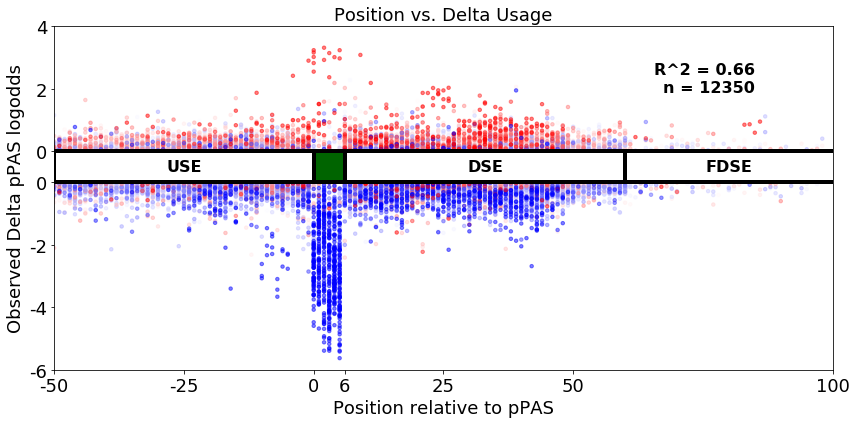

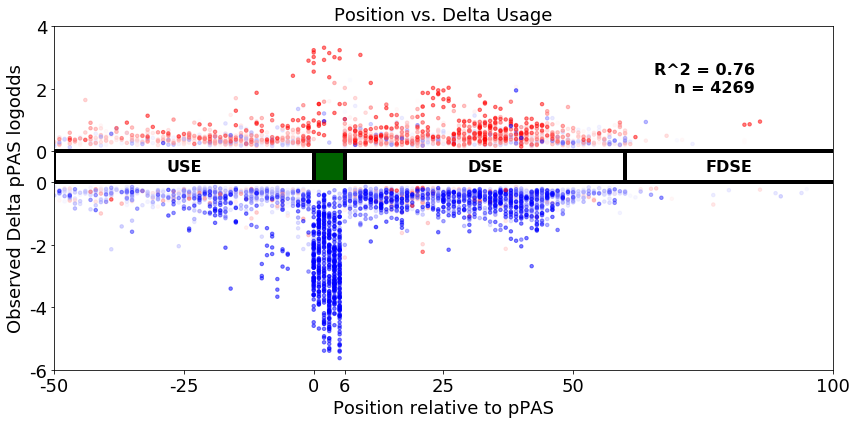

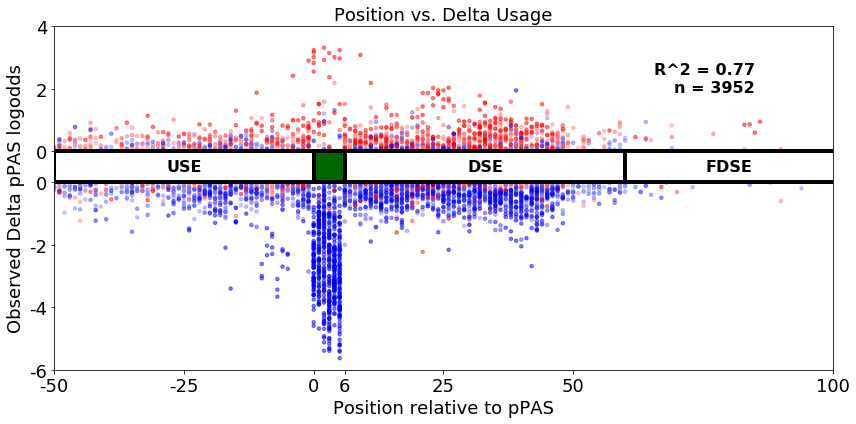

In [48]:
save_figs = False

#All variants
df_to_use = variant_df_filtered

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)

#Significant variants
df_to_use = variant_df_filtered.query("delta_p_val < 0.0001")

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)


#Filtered on prediction >= (log)
df_to_use = variant_df_filtered

fig_name = None
if save_figs :
    fig_name = 'position_delta_all_pred_ge_02'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.2, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)


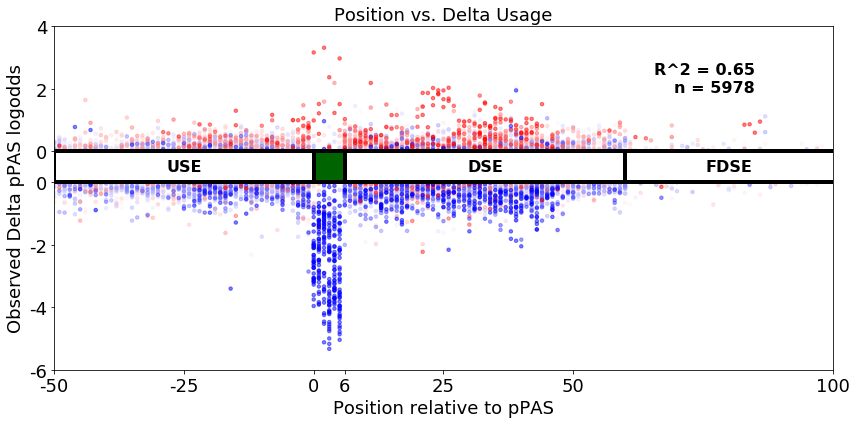

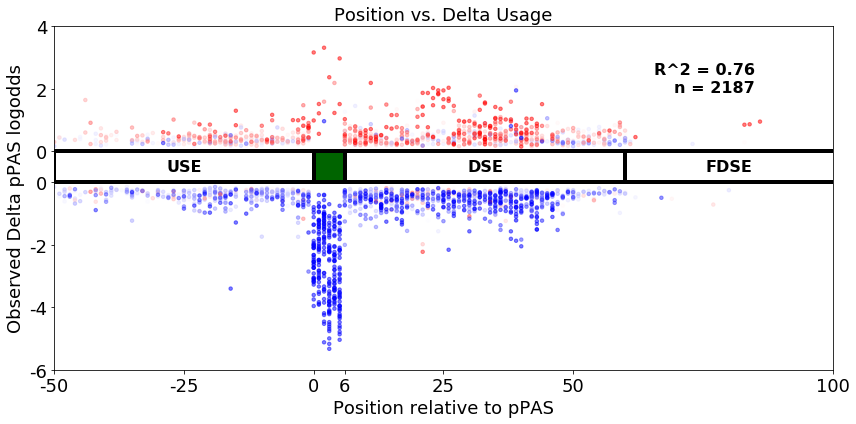

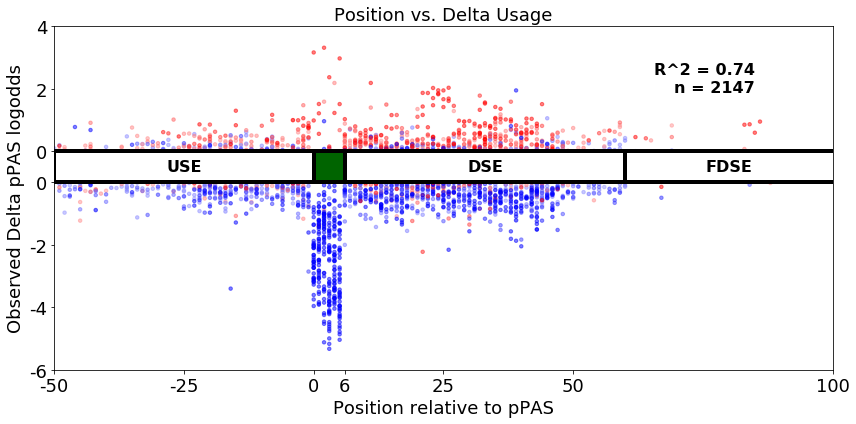

In [49]:
#Held out gene variant prediction tests
save_figs = False

#All variants
df_to_use = variant_df_filtered.loc[variant_df_filtered.gene.isin(held_out_genes)]

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)

#Significant variants
df_to_use = variant_df_filtered.loc[variant_df_filtered.gene.isin(held_out_genes)].query("delta_p_val < 0.0001")

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)


#Filtered on prediction >= (log)
df_to_use = variant_df_filtered.loc[variant_df_filtered.gene.isin(held_out_genes)]

fig_name = None
if save_figs :
    fig_name = 'position_delta_all_pred_ge_02'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.2, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)
